In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import altair as alt
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Load Data (Courtesy of Baseball Savant)
raw_data = pd.read_csv('data/MLB_pitches_13SEP24.csv')

# Restrict to right handed pitchers as lefties will have opposite axis
clean_data = raw_data[raw_data.p_throws == 'R']

# Carry forward the metrics that we would know the instant the ball leaves the pitchers hand
clean_data = clean_data[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'release_extension','release_spin_rate','spin_axis']].copy()

# Drop rows with eephus and screwballs because of small samples and atypical characteristics
drop_list = ['EP','SC']
clean_data = clean_data[clean_data.pitch_type.isin(drop_list) == False]

# Turn pitch_type numeric, grouping into fastballs (1), breaking balls (2), and off speed (3)
clean_data['pitch_type'] = clean_data['pitch_type'].map({
    'FF':1, 
    'FC':1, 
    'SI':1, 
    'CU':2,
    'KC':2,
    'SL':2,
    'ST':2,
    'SV':2,
    'CH':3,
    'FS':3
})

clean_data.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,release_extension,release_spin_rate,spin_axis
0,1,102.9,-2.90,6.35,6.3,2230,220
1,1,102.4,-2.90,6.29,6.2,2396,226
2,1,102.3,-1.75,6.17,6.9,2613,219
3,1,102.0,-2.57,6.40,6.2,2247,222
4,1,102.0,-2.78,6.42,6.1,2359,221


In [3]:
# Confirm sample size
len(clean_data)

3040

In [4]:
# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(clean_data.drop('pitch_type',axis=1), clean_data['pitch_type'], test_size = 0.2, random_state = 42)

# Scale inputs to assure larger values aren't over valued
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [5]:
# Use a Random Forest Model to train and test a model
model = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42).fit(X_train, y_train)
mean_accuracy = model.score(X_test, y_test)
print(mean_accuracy)

0.9802631578947368


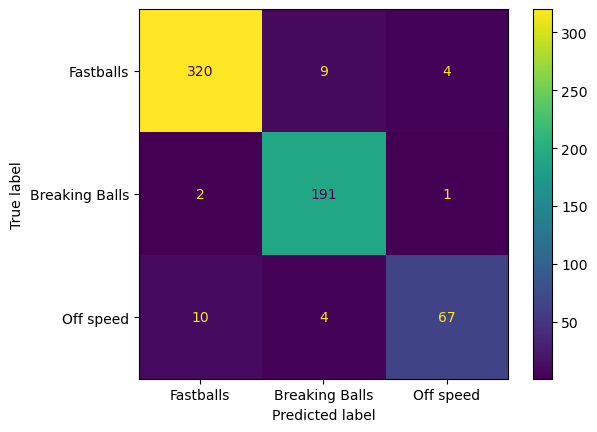

In [6]:
# Use Linear Regression to validate results
lr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
y_pred = lr.predict(X_test)
    
conf_matrix = confusion_matrix(y_test, y_pred)

display_cm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fastballs', 'Breaking Balls', 'Off speed'])
display_cm.plot()
plt.show()

In [7]:
# Investigate what features of a pitch make it most identifiable?
feat_names = clean_data.columns[1:7]
feat_scores = model.feature_importances_
top_feats = list(zip(feat_names, feat_scores))
top_feats = sorted(top_feats, key=lambda tup: tup[1], reverse = True)
top_feats

[('spin_axis', 0.44084825259185295),
 ('release_speed', 0.3084926472259159),
 ('release_spin_rate', 0.1630722726830902),
 ('release_pos_x', 0.03290931384236659),
 ('release_pos_z', 0.032834191275292676),
 ('release_extension', 0.021843322381481574)]

In [8]:
# Prepare data for plotting by renaming pitch type from numeric to group name
clean_data['pitch_type'] = clean_data['pitch_type'].map({
    1: 'Fastball', 
    2: 'Breaking Ball', 
    3: 'Off Speed', 
})

In [9]:
# Create plot for all pitches
pitch_plot = alt.Chart(clean_data).transform_bin(
    field="spin_axis",
    as_="bin",
    bin=alt.BinParams(step=0.5)
).transform_window(
    pitch_count="rank()",
    groupby=["bin"]
).transform_joinaggregate(
    spin_axis_dg="median(spin_axis)",
    groupby=["bin"]
).mark_circle(size=20, clip=True).encode(
    x= alt.X("spin_axis_dg:Q").scale(domain=[0,285]),
    y="pitch_count:Q",
    color=alt.Color('pitch_type', type='nominal').title('Pitch Type').scale(range = ['#377eb8','red','purple'])#domain=column_names, 
).properties(width=900, height=700)

In [10]:
# Create small data frame showing mean spin axis by pitch type
spin_axis_mean = list(clean_data.groupby('pitch_type').spin_axis.mean())
column_names = ['Breaking Ball', 'Fast Ball', 'Off Speed']
vert_lines = pd.DataFrame(list(zip(column_names,spin_axis_mean)),columns=['Pitch_Type','Mean_Spin_Axis'])

In [11]:
# Plot vertical lines of mean spin axis by pitch type
pitch_means = alt.Chart(vert_lines).mark_rule(color="black").encode(x='Mean_Spin_Axis')

labels = alt.Chart(vert_lines).mark_text(align = 'right', baseline ='top', dx = -2, dy = -330).encode(
    alt.X('Mean_Spin_Axis'),
    alt.Text('Pitch_Type')
)

In [12]:
# Combine all plots above
alt.layer(pitch_plot,pitch_means,labels).encode(
    x=alt.X(title='Spin Axis (Degrees)'),
    y=alt.Y(title='Volume')
).properties(
    title='Pitch Type vs. Spin Axis'
)

alt.LayerChart(...)